In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.model_selection
%matplotlib inline

Utilizando los datos de Default construya una curva de precision-recall con los resultados del modelo regresión logística 
(http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html). 
Escriba su propia función. No utilice la de sklearn.

(0, 1)

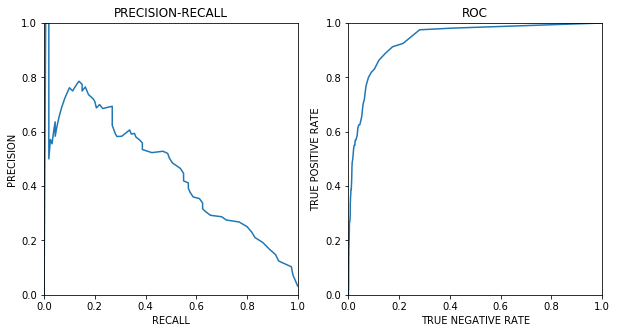

In [55]:
#Load data and define X, Y
data = pd.read_csv('Default.csv')
Y = data['default']
X = data[['balance']]
# Initialize fitting method, fit and predict
f = sklearn.linear_model.LogisticRegression()

# Split in train and test
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X,Y, test_size=0.5)

#  Fit with train
f.fit(X_train, Y_train)

# Predict with test
predict = f.predict(X_test)

# This is the probability for Default='Yes'
proba_yes = f.predict_proba(X_test)[:,1]

# loop over n_p different values for the threshold probabiity
n_p = 100
error_rate = np.zeros(n_p)
precision = np.zeros(n_p)
recall = np.zeros(n_p)
tp_rate = np.zeros(n_p)
tn_rate = np.zeros(n_p)
threshold = np.linspace(0,0.99, n_p)

for i in range(n_p):
    ii = proba_yes>threshold[i]
    predict[ii] = 'Yes'
    predict[~ii] = 'No'
    true_positive = (Y_test == 'Yes') & (predict == 'Yes') 
    false_positive = (Y_test == 'No') & (predict == 'Yes')
    false_negative = (Y_test == 'Yes') & (predict == 'No')
    true_negative = (Y_test == 'No') & (predict == 'No')
    n_tp = np.count_nonzero(true_positive)
    n_fp= np.count_nonzero(false_positive)
    n_fn = np.count_nonzero(false_negative)
    n_tn = np.count_nonzero(true_negative)
    if((n_tp+n_fp)>0): precision[i] = n_tp/(n_tp + n_fp)
    if((n_tp+n_fn)>0): recall[i] = n_tp/(n_tp + n_fn); tp_rate[i] = recall[i]  
    if((n_fp+n_tn)>0): tn_rate[i] = n_fp/(n_fp+n_tn)

        
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(recall, precision)
plt.xlabel('RECALL')
plt.ylabel('PRECISION')
plt.title('PRECISION-RECALL')
plt.xlim([0,1])
plt.ylim([0,1])

plt.subplot(1,2,2)
plt.plot(tn_rate, tp_rate)
plt.xlabel('TRUE NEGATIVE RATE')
plt.ylabel('TRUE POSITIVE RATE')
plt.title('ROC')
plt.xlim([0,1])
plt.ylim([0,1])


b) 
Utilizando el siguiente dataset

https://vincentarelbundock.github.io/Rdatasets/doc/MASS/Boston.html 
https://vincentarelbundock.github.io/Rdatasets/csv/MASS/Boston.csv

encuentre los mejores predictores para saber si un suburbio tiene una rata de crimen mayor o menor a la media. 
Utilice LDA y regresion logistica junto a curvas ROC y Precision-Recall para justificar su respuesta.

In [90]:
def summary_fit(X, Y, f_method, plot=True):
    # Split in train and test
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X,Y, test_size=0.5)

    #  Fit with train
    f_method.fit(X_train, Y_train)

    # Predict with test
    predict = f_method.predict(X_test)

    # This is the probability for the '+' class
    proba_yes = f_method.predict_proba(X_test)[:,1]

    # loop over n_p different values for the threshold probabiity
    n_p = 100
    error_rate = np.zeros(n_p)
    precision = np.zeros(n_p)
    recall = np.zeros(n_p)
    tp_rate = np.zeros(n_p)
    tn_rate = np.zeros(n_p)
    threshold = np.linspace(0,0.99, n_p)

    for i in range(n_p):
        ii = proba_yes>threshold[i]
        predict[ii] = 'Yes'
        predict[~ii] = 'No'
        true_positive = (Y_test == 'Yes') & (predict == 'Yes') 
        false_positive = (Y_test == 'No') & (predict == 'Yes')
        false_negative = (Y_test == 'Yes') & (predict == 'No')
        true_negative = (Y_test == 'No') & (predict == 'No')
        n_tp = np.count_nonzero(true_positive)
        n_fp= np.count_nonzero(false_positive)
        n_fn = np.count_nonzero(false_negative)
        n_tn = np.count_nonzero(true_negative)
        if((n_tp+n_fp)>0): precision[i] = n_tp/(n_tp + n_fp)
        if((n_tp+n_fn)>0): recall[i] = n_tp/(n_tp + n_fn); tp_rate[i] = recall[i]  
        if((n_fp+n_tn)>0): tn_rate[i] = n_fp/(n_fp+n_tn)

    if plot:
        l = 'Predictors:'
        for k in X.keys(): 
            l=l+' '+k
        
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.plot(recall, precision)
        plt.xlabel('RECALL')
        plt.ylabel('PRECISION')
        plt.title('PRECISION-RECALL')
        plt.xlim([0,1])
        plt.ylim([0,1])

        plt.subplot(1,2,2)
        plt.plot(tn_rate, tp_rate, label=l)
        plt.xlabel('TRUE NEGATIVE RATE')
        plt.ylabel('TRUE POSITIVE RATE')
        plt.title('ROC')
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.legend()


In [91]:
data = pd.read_csv('Boston.csv')
crimebinary = np.repeat('Yes', len(data))
ii = np.array(data['crim']>np.median(data['crim']))
crimebinary[ii] = 'Yes'
crimebinary[~ii] = 'No'
data['CRIME_BINARY'] = crimebinary

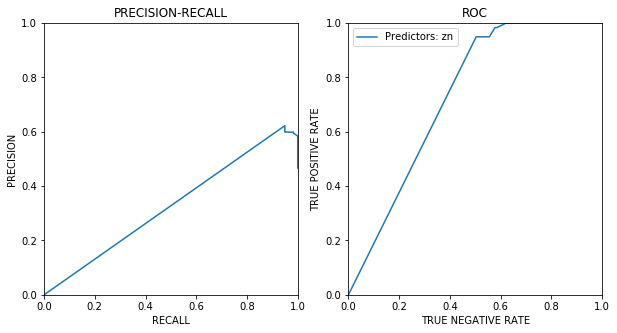

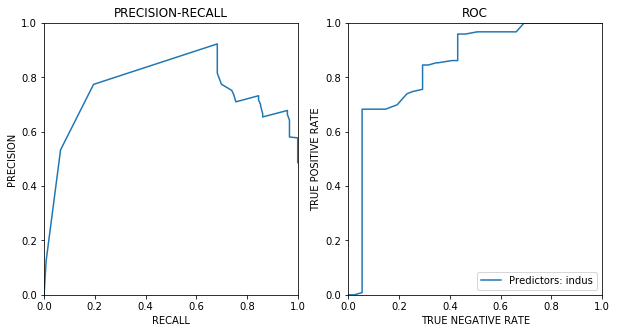

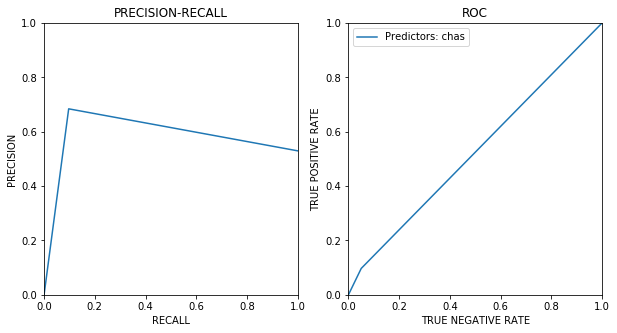

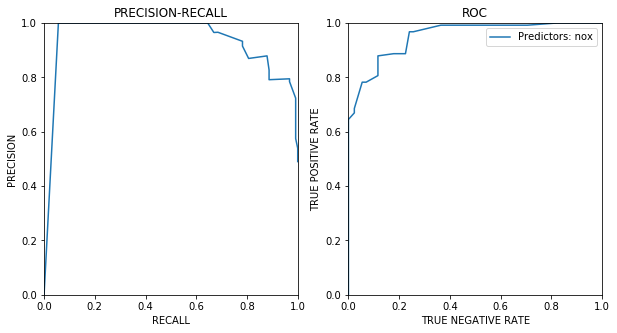

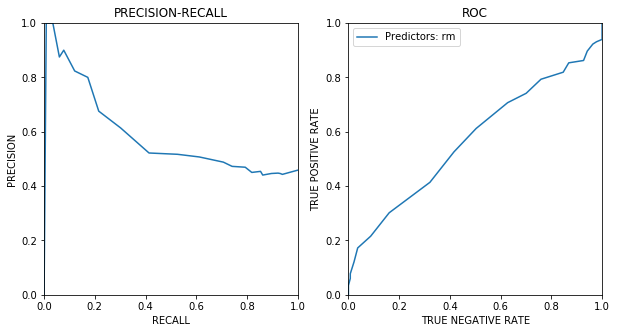

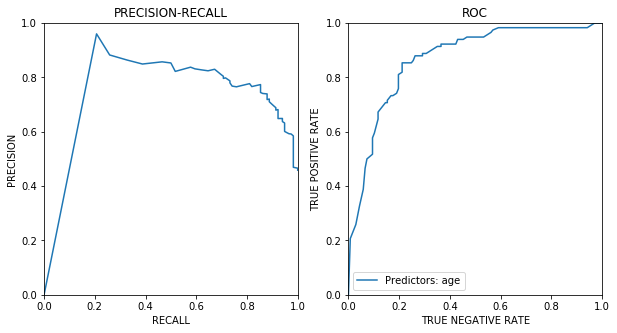

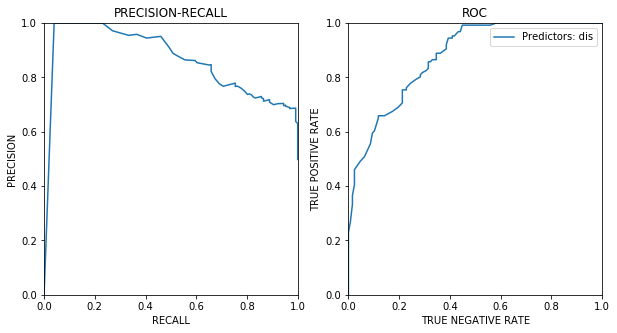

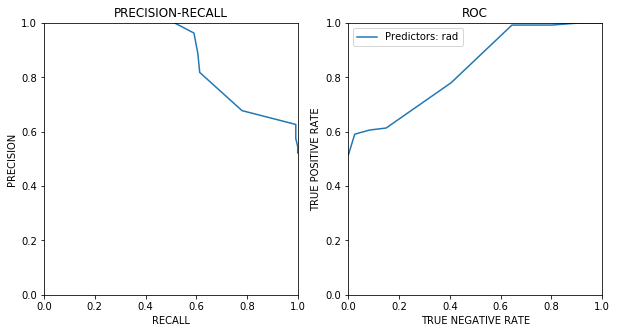

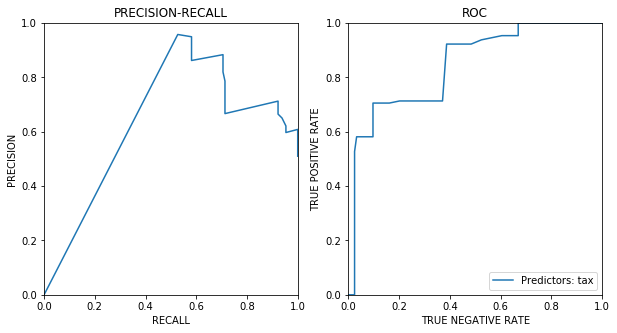

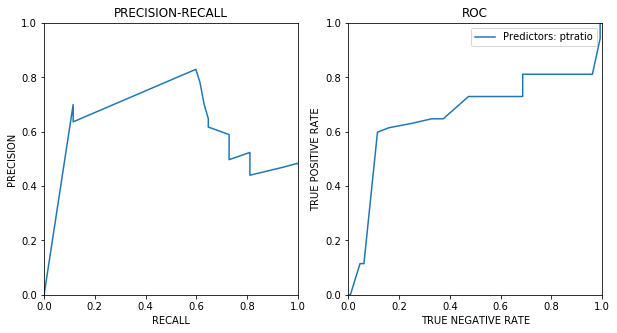

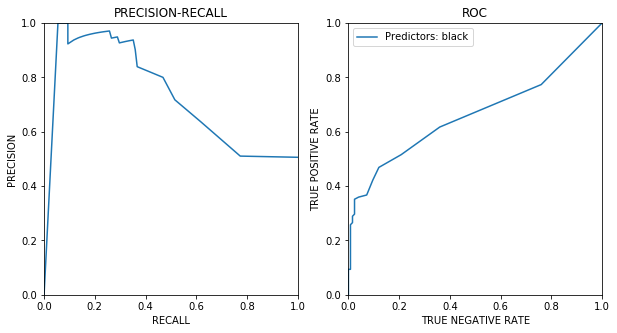

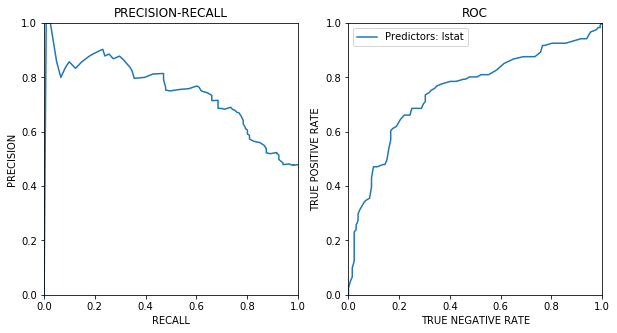

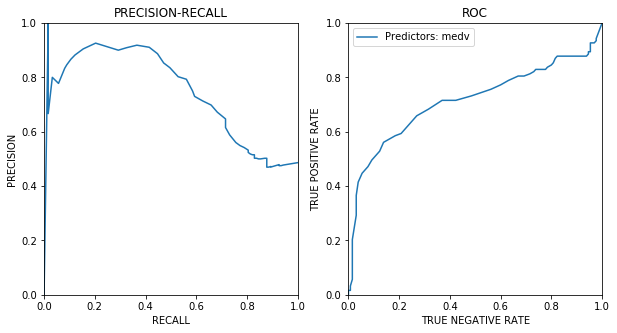

In [93]:
all_predictors = ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat', 'medv']

for k in all_predictors:
    predictors = [k]
    Y = data['CRIME_BINARY']
    X = data[predictors]
    f = sklearn.linear_model.LogisticRegression()
    summary_fit(X, Y, f)

In [64]:
predictors[0]

'zn'

 zn indus chas nox rm age dis rad tax ptratio black lstat medv
